<a href="https://colab.research.google.com/github/leslie-zi-pan/kaggle-courses/blob/main/machine_learning_explainability/Machine_Learning_Explainability_Permutation_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Explainability - Permutation Importance

A common question we might ask a model is what features have the biggest impact on predictions?

This is known as feature importance. 

In this notebook, we will focus on permutation importance. Compared to other methods it is:
- fast to calculate
- widely used and understood
- consistent with properties we would want a feature importance measure to have

## How it works

Consider the data below

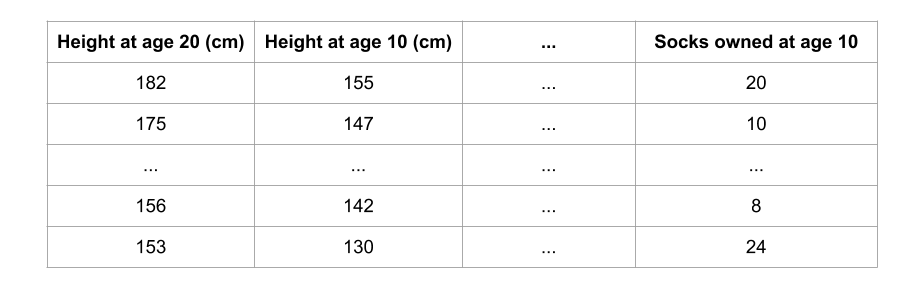

Let's say we want to predict a person's height when they become 20 years old using data that is available at age 10. The data contains useful features (height at age 10), but also features with little predictive power (socks owned), as well as others. 

Permutation importance is calculated after the data is fitted. This therefore wont change the model or what predictions we'd get for a given value of height, sock count etc.

Instead we will ask the question of what happens when we shuffle a single column of the validation data, leaving target and other columns intact. How will that affect the accuracy of prediciton post-shuffle?

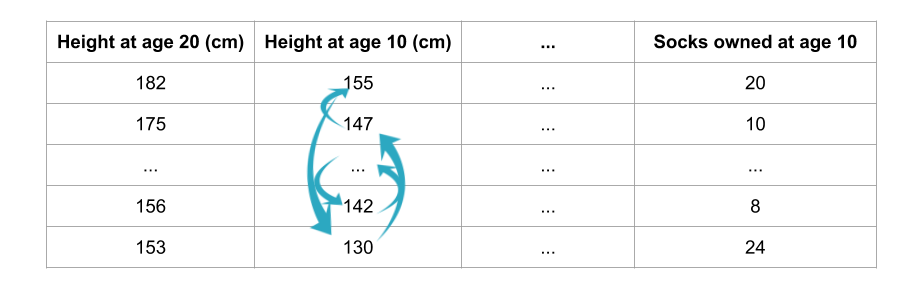

RAndomly re-ordering a single column should cause less accurate predictions. Features of higher importance will affect the predictive accuracy to those with lower predictive importance. 

From this insight we can:
- Get a trained model
- Shuffle the values in a single column, make predictions using the resulting dataset. Use the predictions to calculate how much the loss function suffered from shuffling. (this correlates with teh importance of each feature)
- Return te data to original order. Repeat steps on next column until you have calculated importance of each column. 

## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Kaggle data setup

### Authorise with kaggle json api key

In [ ]:
! pip install kaggle
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Download kaggle dataset

In [ ]:
!kaggle datasets download -d mathan/fifa-2018-match-statistics
!unzip fifa-2018-match-statistics

  0% 0.00/3.86k [00:00<?, ?B/s]
100% 3.86k/3.86k [00:00<00:00, 1.29MB/s]
Archive:  fifa-2018-match-statistics.zip
  inflating: FIFA 2018 Statistics.csv  


## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
print('Setup Complete')

     |████████████████████████████████| 216 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 37.0 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c2788e5c868ebd4ce8a0ac984432c48564f26f322c046065f86f7645ff2e1600
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Setup Complete


## Load the data

In [ ]:
# Path of the file to read
filepath = 'FIFA 2018 Statistics.csv'

# Read the file into a variable flight_delays_data
data = pd.read_csv(filepath)

## Examine data

In [ ]:
data.head(10)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0
5,15-06-2018,Iran,Morocco,1,36,8,2,5,1,2,...,3,0,0,Yes,90.0,Group Stage,No,0,NaN,NaN
6,15-06-2018,Portugal,Spain,3,39,8,3,2,3,4,...,1,0,0,No,4.0,Group Stage,No,0,NaN,NaN
7,15-06-2018,Spain,Portugal,3,61,12,5,5,2,5,...,1,0,0,Yes,24.0,Group Stage,No,0,NaN,NaN
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,1,0,0,Yes,58.0,Group Stage,No,0,NaN,NaN
9,16-06-2018,Australia,France,1,49,4,1,2,1,1,...,3,0,0,No,62.0,Group Stage,No,0,1.0,81.0


In [ ]:
# Print last rows using tail() function
data.tail(10)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
118,07-07-2018,Russia,Croatia,2,38,13,7,4,2,6,...,1,0,0,No,31.0,Quarter Finals,Yes,3,NaN,NaN
119,07-07-2018,Croatia,Russia,2,62,17,3,10,4,8,...,4,0,0,Yes,39.0,Quarter Finals,Yes,4,NaN,NaN
120,10-07-2018,France,Belgium,1,40,19,5,8,6,4,...,2,0,0,Yes,51.0,Semi- Finals,No,0,NaN,NaN
121,10-07-2018,Belgium,France,0,60,9,3,5,1,5,...,3,0,0,No,NaN,Semi- Finals,No,0,NaN,NaN
122,11-07-2018,Croatia,England,2,54,22,7,11,4,8,...,2,0,0,Yes,68.0,Semi- Finals,No,0,NaN,NaN
123,11-07-2018,England,Croatia,1,46,11,1,6,4,4,...,1,0,0,No,5.0,Semi- Finals,No,0,NaN,NaN
124,14-07-2018,Belgium,England,2,43,12,4,3,5,4,...,1,0,0,Yes,4.0,3rd Place,No,0,NaN,NaN
125,14-07-2018,England,Belgium,0,57,15,5,7,3,5,...,2,0,0,No,NaN,3rd Place,No,0,NaN,NaN
126,15-07-2018,France,Croatia,4,39,8,6,1,1,2,...,2,0,0,Yes,18.0,Final,No,0,1.0,18.0
127,15-07-2018,Croatia,France,2,61,15,3,8,4,6,...,1,0,0,No,28.0,Final,No,0,NaN,NaN


## Permutation importance example

In [ ]:
y = (data['Man of the Match'] == 'Yes')
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train_X, train_y)

RandomForestClassifier(random_state=0)

Permutaion importance using eli5 library

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


## Interpreting Permutation Importances

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was Goals scored. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.